In [1]:
#GAN for image generation
#https://www.youtube.com/watch?v=ABaZ_tecZ3U&list=PLWKjhJtqVAbm3T2Eq1_KgloC7ogdXxdRa&index=6

import os
import torch
import torchvision
import torchvision.transforms as tt
import tarfile
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

%matplotlib inline

In [11]:
 #Get the parent directory and enter files
DATA_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + '\\data_source\\anime-faces-images'


print(os.listdir(DATA_DIR +'\\images')[:10])

['10000_2004.jpg', '10001_2004.jpg', '10002_2004.jpg', '10003_2004.jpg', '10004_2004.jpg', '10005_2004.jpg', '10006_2004.jpg', '10007_2004.jpg', '10008_2004.jpg', '10009_2004.jpg']


In [12]:
image_size = 64
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    #tt.RandomHorizontalFlip(),
    #tt.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    tt.Resize((image_size, image_size)),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)
]))

train_dl = DataLoader(train_ds, batch_size,shuffle=True, num_workers=4, pin_memory = True)

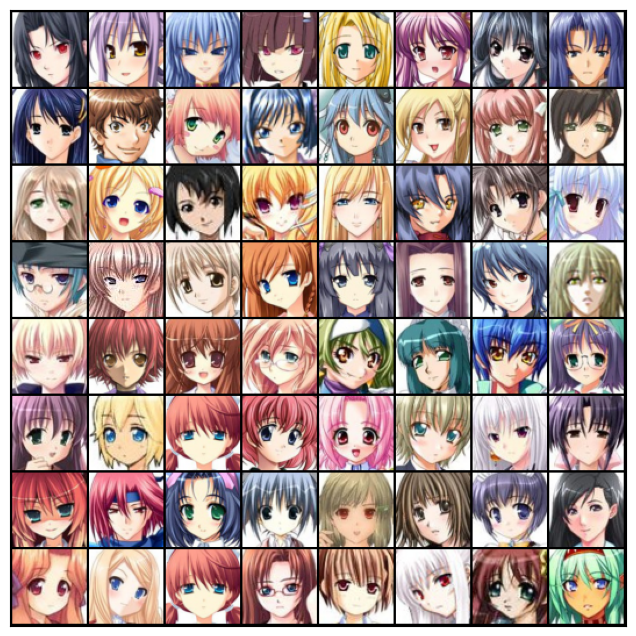

In [13]:

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0))

def show_batch(dl,nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

show_batch(train_dl)


In [2]:
#Utilize GPU

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensors to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    "Wrap a dataloader to move data to a device"
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
device = get_default_device()
print("device: ", device)

train_dl = DeviceDataLoader(train_dl, device)

device:  cuda


NameError: name 'train_dl' is not defined

In [5]:
# ------------------------------
# Mapping Network
# ------------------------------
class MappingNetwork(nn.Module):
    def __init__(self, latent_dim, num_layers):
        super(MappingNetwork, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Linear(latent_dim, latent_dim))
            layers.append(nn.LeakyReLU(0.2))
        self.mapping = nn.Sequential(*layers)

    def forward(self, z):
        return self.mapping(z)

# ------------------------------
# Adaptive Instance Normalization (AdaIN)
# ------------------------------
def adain(x, style):
    mean = x.mean(dim=[2, 3], keepdim=True)
    std = x.std(dim=[2, 3], keepdim=True)
    style_mean, style_std = style.chunk(2, dim=1)
    style_mean = style_mean.unsqueeze(-1).unsqueeze(-1)
    style_std = style_std.unsqueeze(-1).unsqueeze(-1)
    return style_std * (x - mean) / (std + 1e-8) + style_mean

# ------------------------------
# StyleGAN Generator
# ------------------------------
class StyleGANGenerator(nn.Module):
    def __init__(self, latent_dim, img_channels, base_channels):
        super(StyleGANGenerator, self).__init__()
        self.latent_dim = latent_dim

        # Mapping Network
        self.mapping = MappingNetwork(latent_dim, num_layers=8)

        # Fixed starting input
        self.constant_input = nn.Parameter(torch.randn(1, base_channels, 4, 4))

        # Progressive layers
        self.prog_blocks = nn.ModuleList([
            GeneratorBlock(base_channels // (2**i), base_channels // (2**(i + 1)), latent_dim)
            for i in range(4)  # 4x4 -> 8x8 -> 16x16 -> 32x32 -> 64x64
        ])

        # Final RGB conversion layer
        self.to_rgb = nn.Conv2d(base_channels // (2**(4)), img_channels, kernel_size=1)

    def forward(self, z):
        style = self.mapping(z)
        x = self.constant_input.repeat(z.size(0), 1, 1, 1)  #creates batch number of constant_input

        # Pass through progressive blocks
        for block in self.prog_blocks:
            x = block(x, style)

        # Final RGB conversion
        rgb = self.to_rgb(x)

        return torch.tanh(rgb)


# ------------------------------
# Generator Block
# ------------------------------
class GeneratorBlock(nn.Module):
    def __init__(self, in_channels, out_channels, style_dim):
        super(GeneratorBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.style1 = nn.Linear(style_dim, out_channels * 2)
        self.style2 = nn.Linear(style_dim, out_channels * 2)
        self.noise1 = nn.Parameter(torch.randn(1, out_channels * 2 , 1, 1))
        self.noise2 = nn.Parameter(torch.randn(1, out_channels , 1, 1))
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

    def forward(self, x, style):
        x = self.upsample(x)
        noise = torch.randn(x.size(0), 1, x.size(2), x.size(3), device=device)  # Noise for first layer
        style1 = self.style1(style)
        # print("x.shape: ", x.shape)
        # print("noise.shape: ", noise.shape)
        # print("self.noise1.shape: ",self.noise1.shape)  #!!!
        # print("style1.shape: ", style1.shape)
        x = adain(F.leaky_relu(self.conv1(x + self.noise1 * noise), 0.2), style1)

        noise = torch.randn(x.size(0), 1, x.size(2), x.size(3), device=device)  # Noise for second layer
        style2 = self.style2(style)
        # print("x.shape: ", x.shape)
        # print("noise.shape: ", noise.shape)
        # print("self.noise2.shape: ",self.noise2.shape)  #!!!
        # print("style2.shape: ", style2.shape)
        x = adain(F.leaky_relu(self.conv2(x + self.noise2 * noise), 0.2), style2)

        return x



In [4]:
# ------------------------------
# StyleGAN Discriminator
# ------------------------------
class StyleGANDiscriminator(nn.Module):
    def __init__(self, img_channels, base_channels):
        super(StyleGANDiscriminator, self).__init__()

        # Progressive blocks
        self.prog_blocks = nn.ModuleList([
            DiscriminatorBlock(base_channels // (2**i), base_channels // (2**(i + 1)))
            for i in range(4)  # For 64x64 -> 32x32 -> 16x16 -> 8x8 -> 4x4
        ])

        # From RGB conversion layer
        self.from_rgb = nn.Conv2d(img_channels, base_channels, kernel_size=1)

        # Final layer
        self.final_conv = nn.Conv2d(base_channels // (2**4), 1, kernel_size=4)

    def forward(self, x):
        x = self.from_rgb(x)
        for block in self.prog_blocks:
            x = block(x)
        x = self.final_conv(x)
        return x.view(x.size(0))  # Flatten to [batch_size]


# ------------------------------
# Discriminator Block
# ------------------------------
class DiscriminatorBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DiscriminatorBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.downsample = nn.AvgPool2d(2)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = self.downsample(x)
        return x



In [8]:
"""
1-Adversarial Loss: Use Wasserstein Loss with Gradient Penalty for stability
2-Gradient Penalty: Penalize gradients of the discriminator to enforce Lipschitz continuity
"""

def gradient_penalty(D, real_images, fake_images, device):
    batch_size, C, H, W = real_images.size()
    epsilon = torch.rand(batch_size, 1, 1, 1, device=device)
    interpolated = epsilon * real_images + (1 - epsilon) * fake_images
    interpolated.requires_grad_(True)
    interpolated_score = D(interpolated)
    grad_outputs = torch.ones_like(interpolated_score, device=device)
    gradients = torch.autograd.grad(
        outputs=interpolated_score,
        inputs=interpolated,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
    )[0]
    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    return ((gradient_norm - 1) ** 2).mean()

In [9]:
"""R1 Regularization instead of Gradient Penalty"""
def r1_regularization(real_images,real_scores,device):
    real_images.requires_grad_(True)
    grad_outputs=torch.ones_like(real_scores, device=device)
    gradients = torch.autograd.grad(
        outputs=real_scores,
        inputs=real_images,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
    )[0]
    gradients = gradients.view(real_images.size(0), -1)
    return (gradients.norm(2, dim=1) ** 2).mean()

In [10]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok = True)

def save_images(images,index, show = True):
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]), ax.set_yticks([])
        ax.imshow(make_grid(images.cpu().detach(), nrow=8).permute(1,2,0))

In [11]:
#Training Loop

def train_stylegan(generator, discriminator, dataloader, epochs, latent_dim, device):
    torch.cuda.empty_cache()

    g_loss_history = []
    d_loss_history = []
    real_scores_history = []
    fake_scores_history = []

    # Optimizers
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=5e-4, betas=(0.0, 0.99))
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=5e-4, betas=(0.0, 0.99))

    # Loss weights
    gradient_penalty_weight = 10.0
    r1_penalty_weight = 10.0

    for epoch in range(epochs):
        for real_images, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            #Adding noise to obtain stochastic features
            #real_images = real_images + torch.randn_like(real_images) * 0.05
            real_images = real_images.to(device)
            real_images.requires_grad_(True)
            # ------------------------------
            # Train Discriminator
            # ------------------------------
            z = torch.randn(real_images.size(0), latent_dim, device=device)
            fake_images = generator(z)

            #Adding noise to obtain stochastic features
            #fake_images = fake_images + torch.randn_like(fake_images) * 0.05 

            real_scores = discriminator(real_images)
            fake_scores = discriminator(fake_images.detach())

            #gp = gradient_penalty(discriminator, real_images, fake_images, device)
            #d_loss = (-1.0) * real_scores.mean() + fake_scores.mean() + gradient_penalty_weight * gp

            r1 = r1_regularization(real_images, real_scores, device)
            d_loss = (-1.0) * real_scores.mean() + fake_scores.mean() + r1_penalty_weight/2 * r1

            #print("Discriminator - r1: ", r1, " real_scores.mean(): ", real_scores.mean(), " fake_scores.mean(): ", fake_scores.mean(), " d_loss: ", d_loss) #!!!

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # ------------------------------
            # Train Generator
            # ------------------------------
            z = torch.randn(real_images.size(0), latent_dim, device=device)
            fake_images = generator(z)


            #Adding noise to obtain stochastic features
            #fake_images = fake_images + torch.randn_like(fake_images) * 0.05

            fake_scores = discriminator(fake_images)

            g_loss = (-1.0) * fake_scores.mean()

            #print("Generator - g_loss: ", g_loss)   #!!!

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()


        #Record losses & scores
        g_loss_history.append(g_loss)
        d_loss_history.append(d_loss)
        real_scores_history.append(real_scores.mean())
        fake_scores_history.append(fake_scores.mean())

        print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")
        print("r1: ", r1.item(), " real_scores.mean(): ", real_scores.mean().item(), " fake_scores.mean(): ", fake_scores.mean().item())

        # Save generated images
        save_images(fake_images, epoch, show=False)
    
    return g_loss_history, d_loss_history, real_scores_history, fake_scores_history


In [12]:
# Initialize models
latent_dim = 512
img_channels = 3
base_channels = 512
epochs = 150

generator = StyleGANGenerator(latent_dim, img_channels, base_channels).to(device)
discriminator = StyleGANDiscriminator(img_channels, base_channels).to(device)

# Train
history = train_stylegan(
    generator=generator,
    discriminator=discriminator,
    dataloader=train_dl,
    epochs=epochs,
    latent_dim=latent_dim,
    device=device
)


Epoch 1/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 1/150 | D Loss: 0.4498 | G Loss: -5.3209
r1:  0.004345287103205919  real_scores.mean():  8.520511627197266  fake_scores.mean():  5.320893287658691
Saving generated-images-0000.png


Epoch 2/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 2/150 | D Loss: 0.0112 | G Loss: 0.2117
r1:  0.00032325153006240726  real_scores.mean():  -0.2909153997898102  fake_scores.mean():  -0.211684912443161
Saving generated-images-0001.png


Epoch 3/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 3/150 | D Loss: -0.2514 | G Loss: 48.6268
r1:  0.13976025581359863  real_scores.mean():  -47.807395935058594  fake_scores.mean():  -48.62675476074219
Saving generated-images-0002.png


Epoch 4/150: 100%|██████████| 354/354 [03:33<00:00,  1.66it/s]


Epoch 4/150 | D Loss: 0.0231 | G Loss: 14.7726
r1:  0.003758706385269761  real_scores.mean():  -13.757144927978516  fake_scores.mean():  -14.77261734008789
Saving generated-images-0003.png


Epoch 5/150: 100%|██████████| 354/354 [03:33<00:00,  1.66it/s]


Epoch 5/150 | D Loss: 0.0198 | G Loss: 1.0230
r1:  0.00018250274297315627  real_scores.mean():  -1.1893407106399536  fake_scores.mean():  -1.022970199584961
Saving generated-images-0004.png


Epoch 6/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 6/150 | D Loss: -7.0135 | G Loss: 16.6286
r1:  0.016968747600913048  real_scores.mean():  -1.5044846534729004  fake_scores.mean():  -16.628612518310547
Saving generated-images-0005.png


Epoch 7/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 7/150 | D Loss: -133.6464 | G Loss: 790.2277
r1:  18.947534561157227  real_scores.mean():  -282.660888671875  fake_scores.mean():  -790.2277221679688
Saving generated-images-0006.png


Epoch 8/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 8/150 | D Loss: -96.4597 | G Loss: 569.9326
r1:  36.89786148071289  real_scores.mean():  -448.71099853515625  fake_scores.mean():  -569.9326171875
Saving generated-images-0007.png


Epoch 9/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 9/150 | D Loss: -0.4472 | G Loss: 15.5155
r1:  0.09993709623813629  real_scores.mean():  -15.763976097106934  fake_scores.mean():  -15.515493392944336
Saving generated-images-0008.png


Epoch 10/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 10/150 | D Loss: -0.3273 | G Loss: 6.8380
r1:  0.08846606314182281  real_scores.mean():  0.5183779001235962  fake_scores.mean():  -6.837985038757324
Saving generated-images-0009.png


Epoch 11/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 11/150 | D Loss: -0.3290 | G Loss: 0.6995
r1:  0.07114984840154648  real_scores.mean():  1.400547981262207  fake_scores.mean():  -0.6994860172271729
Saving generated-images-0010.png


Epoch 12/150: 100%|██████████| 354/354 [03:32<00:00,  1.66it/s]


Epoch 12/150 | D Loss: -0.3957 | G Loss: -0.6161
r1:  0.04471958056092262  real_scores.mean():  0.7235782146453857  fake_scores.mean():  0.6160552501678467
Saving generated-images-0011.png


Epoch 13/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 13/150 | D Loss: -0.2516 | G Loss: -1.7102
r1:  0.04345916211605072  real_scores.mean():  2.981712579727173  fake_scores.mean():  1.710162878036499
Saving generated-images-0012.png


Epoch 14/150: 100%|██████████| 354/354 [03:34<00:00,  1.65it/s]


Epoch 14/150 | D Loss: -0.1612 | G Loss: -0.9514
r1:  0.018369119614362717  real_scores.mean():  1.309106469154358  fake_scores.mean():  0.9514212608337402
Saving generated-images-0013.png


Epoch 15/150: 100%|██████████| 354/354 [03:34<00:00,  1.65it/s]


Epoch 15/150 | D Loss: -0.0933 | G Loss: -0.2420
r1:  0.025109760463237762  real_scores.mean():  0.5523085594177246  fake_scores.mean():  0.2419920563697815
Saving generated-images-0014.png


Epoch 16/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 16/150 | D Loss: 0.0056 | G Loss: 1.2390
r1:  0.021965360268950462  real_scores.mean():  0.48232120275497437  fake_scores.mean():  -1.2390309572219849
Saving generated-images-0015.png


Epoch 17/150: 100%|██████████| 354/354 [03:36<00:00,  1.64it/s]


Epoch 17/150 | D Loss: 0.0266 | G Loss: 0.7402
r1:  0.015803439542651176  real_scores.mean():  0.20047341287136078  fake_scores.mean():  -0.7402489185333252
Saving generated-images-0016.png


Epoch 18/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 18/150 | D Loss: 0.0962 | G Loss: -0.0271
r1:  0.0018550797831267118  real_scores.mean():  -0.25940337777137756  fake_scores.mean():  0.027137447148561478
Saving generated-images-0017.png


Epoch 19/150: 100%|██████████| 354/354 [03:32<00:00,  1.66it/s]


Epoch 19/150 | D Loss: -0.0280 | G Loss: -0.1946
r1:  0.0008488554740324616  real_scores.mean():  0.2676315903663635  fake_scores.mean():  0.19463396072387695
Saving generated-images-0018.png


Epoch 20/150: 100%|██████████| 354/354 [03:32<00:00,  1.66it/s]


Epoch 20/150 | D Loss: -0.0840 | G Loss: 1.0167
r1:  0.015388654544949532  real_scores.mean():  0.2743147015571594  fake_scores.mean():  -1.016737461090088
Saving generated-images-0019.png


Epoch 21/150: 100%|██████████| 354/354 [03:32<00:00,  1.66it/s]


Epoch 21/150 | D Loss: -0.2899 | G Loss: -0.7097
r1:  0.04718736931681633  real_scores.mean():  0.542386531829834  fake_scores.mean():  0.7097012996673584
Saving generated-images-0020.png


Epoch 22/150: 100%|██████████| 354/354 [03:33<00:00,  1.66it/s]


Epoch 22/150 | D Loss: -0.1944 | G Loss: -0.0900
r1:  0.026838839054107666  real_scores.mean():  1.114964246749878  fake_scores.mean():  0.08999380469322205
Saving generated-images-0021.png


Epoch 23/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 23/150 | D Loss: -0.1431 | G Loss: -0.4630
r1:  0.029667899012565613  real_scores.mean():  0.5159552693367004  fake_scores.mean():  0.4630243182182312
Saving generated-images-0022.png


Epoch 24/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 24/150 | D Loss: -0.0975 | G Loss: -0.0911
r1:  0.025720182806253433  real_scores.mean():  0.47053074836730957  fake_scores.mean():  0.09105940908193588
Saving generated-images-0023.png


Epoch 25/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 25/150 | D Loss: -0.0862 | G Loss: -0.3144
r1:  0.020989643409848213  real_scores.mean():  0.4696217179298401  fake_scores.mean():  0.31442177295684814
Saving generated-images-0024.png


Epoch 26/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 26/150 | D Loss: -0.0544 | G Loss: 0.1938
r1:  0.016078004613518715  real_scores.mean():  0.8067168593406677  fake_scores.mean():  -0.19380933046340942
Saving generated-images-0025.png


Epoch 27/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 27/150 | D Loss: -0.0767 | G Loss: -0.7093
r1:  0.02107011340558529  real_scores.mean():  0.6714723706245422  fake_scores.mean():  0.7093185186386108
Saving generated-images-0026.png


Epoch 28/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 28/150 | D Loss: 0.2067 | G Loss: 0.8509
r1:  0.024958224967122078  real_scores.mean():  0.7408434152603149  fake_scores.mean():  -0.8509296178817749
Saving generated-images-0027.png


Epoch 29/150: 100%|██████████| 354/354 [03:32<00:00,  1.66it/s]


Epoch 29/150 | D Loss: -0.0756 | G Loss: 0.4223
r1:  0.020703893154859543  real_scores.mean():  0.788302481174469  fake_scores.mean():  -0.422342985868454
Saving generated-images-0028.png


Epoch 30/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 30/150 | D Loss: -0.1461 | G Loss: 0.3643
r1:  0.01669364795088768  real_scores.mean():  0.04360339790582657  fake_scores.mean():  -0.3642982840538025
Saving generated-images-0029.png


Epoch 31/150: 100%|██████████| 354/354 [03:32<00:00,  1.66it/s]


Epoch 31/150 | D Loss: -0.0872 | G Loss: 0.6075
r1:  0.009770810604095459  real_scores.mean():  -0.642305314540863  fake_scores.mean():  -0.6075015664100647
Saving generated-images-0030.png


Epoch 32/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 32/150 | D Loss: -0.1363 | G Loss: 0.4290
r1:  0.01309057604521513  real_scores.mean():  0.00802529789507389  fake_scores.mean():  -0.4289616346359253
Saving generated-images-0031.png


Epoch 33/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 33/150 | D Loss: -0.0590 | G Loss: 0.3377
r1:  0.019126608967781067  real_scores.mean():  0.886704683303833  fake_scores.mean():  -0.3376501798629761
Saving generated-images-0032.png


Epoch 34/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 34/150 | D Loss: -0.0355 | G Loss: -0.4273
r1:  0.021995000541210175  real_scores.mean():  0.5412324666976929  fake_scores.mean():  0.4273378551006317
Saving generated-images-0033.png


Epoch 35/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 35/150 | D Loss: -0.0942 | G Loss: -1.0472
r1:  0.015815138816833496  real_scores.mean():  0.25708073377609253  fake_scores.mean():  1.0472139120101929
Saving generated-images-0034.png


Epoch 36/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 36/150 | D Loss: -0.0794 | G Loss: -0.1418
r1:  0.01609467715024948  real_scores.mean():  0.5488616824150085  fake_scores.mean():  0.14176231622695923
Saving generated-images-0035.png


Epoch 37/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 37/150 | D Loss: -0.0828 | G Loss: 0.5198
r1:  0.013932382687926292  real_scores.mean():  0.12362724542617798  fake_scores.mean():  -0.5198124051094055
Saving generated-images-0036.png


Epoch 38/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 38/150 | D Loss: -0.0622 | G Loss: -0.0285
r1:  0.017890872433781624  real_scores.mean():  0.16882210969924927  fake_scores.mean():  0.028518222272396088
Saving generated-images-0037.png


Epoch 39/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 39/150 | D Loss: -0.0825 | G Loss: 0.7646
r1:  0.015264570713043213  real_scores.mean():  0.12030909955501556  fake_scores.mean():  -0.7645844221115112
Saving generated-images-0038.png


Epoch 40/150: 100%|██████████| 354/354 [03:32<00:00,  1.66it/s]


Epoch 40/150 | D Loss: -0.0794 | G Loss: 0.4208
r1:  0.013789894990622997  real_scores.mean():  -0.11333660781383514  fake_scores.mean():  -0.4207746982574463
Saving generated-images-0039.png


Epoch 41/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 41/150 | D Loss: -0.0619 | G Loss: -0.1301
r1:  0.01691301167011261  real_scores.mean():  0.01949382573366165  fake_scores.mean():  0.13012249767780304
Saving generated-images-0040.png


Epoch 42/150: 100%|██████████| 354/354 [03:33<00:00,  1.66it/s]


Epoch 42/150 | D Loss: -0.0498 | G Loss: 0.7881
r1:  0.005530538037419319  real_scores.mean():  -1.0203609466552734  fake_scores.mean():  -0.7880582809448242
Saving generated-images-0041.png


Epoch 43/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 43/150 | D Loss: -0.0737 | G Loss: 0.4700
r1:  0.015956107527017593  real_scores.mean():  0.31676629185676575  fake_scores.mean():  -0.4699588716030121
Saving generated-images-0042.png


Epoch 44/150: 100%|██████████| 354/354 [03:32<00:00,  1.66it/s]


Epoch 44/150 | D Loss: -0.0595 | G Loss: 0.0306
r1:  0.0011791541473940015  real_scores.mean():  0.014643318019807339  fake_scores.mean():  -0.030589256435632706
Saving generated-images-0043.png


Epoch 45/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 45/150 | D Loss: -0.0566 | G Loss: -0.0727
r1:  0.017794301733374596  real_scores.mean():  0.16543059051036835  fake_scores.mean():  0.07270351052284241
Saving generated-images-0044.png


Epoch 46/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 46/150 | D Loss: -0.1077 | G Loss: -0.1764
r1:  0.014507637359201908  real_scores.mean():  0.4340517520904541  fake_scores.mean():  0.17639042437076569
Saving generated-images-0045.png


Epoch 47/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 47/150 | D Loss: -0.0460 | G Loss: -0.6421
r1:  0.01105538196861744  real_scores.mean():  0.855542778968811  fake_scores.mean():  0.6421250104904175
Saving generated-images-0046.png


Epoch 48/150: 100%|██████████| 354/354 [03:36<00:00,  1.63it/s]


Epoch 48/150 | D Loss: 0.0363 | G Loss: -0.2493
r1:  0.015931766480207443  real_scores.mean():  0.0428399033844471  fake_scores.mean():  0.24929910898208618
Saving generated-images-0047.png


Epoch 49/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 49/150 | D Loss: -0.0492 | G Loss: -0.2822
r1:  0.01097254641354084  real_scores.mean():  0.4331856966018677  fake_scores.mean():  0.282201886177063
Saving generated-images-0048.png


Epoch 50/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 50/150 | D Loss: -0.0312 | G Loss: 0.9330
r1:  0.015523620881140232  real_scores.mean():  0.5519312620162964  fake_scores.mean():  -0.93300461769104
Saving generated-images-0049.png


Epoch 51/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 51/150 | D Loss: -0.0550 | G Loss: -0.4077
r1:  0.0127146877348423  real_scores.mean():  0.12206868827342987  fake_scores.mean():  0.4077434539794922
Saving generated-images-0050.png


Epoch 52/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 52/150 | D Loss: -0.0602 | G Loss: 0.5130
r1:  0.015124112367630005  real_scores.mean():  0.08703270554542542  fake_scores.mean():  -0.5130053162574768
Saving generated-images-0051.png


Epoch 53/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 53/150 | D Loss: -0.0814 | G Loss: -0.6170
r1:  0.013000390492379665  real_scores.mean():  -0.23106911778450012  fake_scores.mean():  0.6169873476028442
Saving generated-images-0052.png


Epoch 54/150: 100%|██████████| 354/354 [03:32<00:00,  1.66it/s]


Epoch 54/150 | D Loss: -0.0737 | G Loss: -0.1316
r1:  0.011127027682960033  real_scores.mean():  0.17492815852165222  fake_scores.mean():  0.13164986670017242
Saving generated-images-0053.png


Epoch 55/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 55/150 | D Loss: -0.0587 | G Loss: -0.0312
r1:  0.01246801856905222  real_scores.mean():  0.1490669846534729  fake_scores.mean():  0.031156694516539574
Saving generated-images-0054.png


Epoch 56/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 56/150 | D Loss: -0.0412 | G Loss: -0.3251
r1:  0.010960771702229977  real_scores.mean():  0.39143508672714233  fake_scores.mean():  0.32510241866111755
Saving generated-images-0055.png


Epoch 57/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 57/150 | D Loss: -0.0770 | G Loss: -0.6317
r1:  0.01019508671015501  real_scores.mean():  -0.31883901357650757  fake_scores.mean():  0.6317402124404907
Saving generated-images-0056.png


Epoch 58/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 58/150 | D Loss: -0.0064 | G Loss: 0.0445
r1:  0.012579199858009815  real_scores.mean():  0.9740139245986938  fake_scores.mean():  -0.04449024796485901
Saving generated-images-0057.png


Epoch 59/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 59/150 | D Loss: -0.0116 | G Loss: -0.1274
r1:  0.012622363865375519  real_scores.mean():  0.6551579833030701  fake_scores.mean():  0.12741558253765106
Saving generated-images-0058.png


Epoch 60/150: 100%|██████████| 354/354 [03:33<00:00,  1.66it/s]


Epoch 60/150 | D Loss: -0.0482 | G Loss: 0.1615
r1:  0.012130551040172577  real_scores.mean():  -0.3063904643058777  fake_scores.mean():  -0.16148945689201355
Saving generated-images-0059.png


Epoch 61/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 61/150 | D Loss: -0.0788 | G Loss: 0.1909
r1:  0.012138095684349537  real_scores.mean():  0.33909016847610474  fake_scores.mean():  -0.19094982743263245
Saving generated-images-0060.png


Epoch 62/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 62/150 | D Loss: -0.0357 | G Loss: 0.0518
r1:  0.01299071405082941  real_scores.mean():  -0.027099106460809708  fake_scores.mean():  -0.0517844557762146
Saving generated-images-0061.png


Epoch 63/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 63/150 | D Loss: 0.0517 | G Loss: -0.1642
r1:  0.011666285805404186  real_scores.mean():  0.2549450695514679  fake_scores.mean():  0.1642099916934967
Saving generated-images-0062.png


Epoch 64/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 64/150 | D Loss: -0.0756 | G Loss: 0.2403
r1:  0.010582316666841507  real_scores.mean():  0.09824199974536896  fake_scores.mean():  -0.2403365522623062
Saving generated-images-0063.png


Epoch 65/150: 100%|██████████| 354/354 [03:33<00:00,  1.66it/s]


Epoch 65/150 | D Loss: -0.0516 | G Loss: 0.0801
r1:  0.009674489498138428  real_scores.mean():  0.4240918457508087  fake_scores.mean():  -0.08013196289539337
Saving generated-images-0064.png


Epoch 66/150: 100%|██████████| 354/354 [03:33<00:00,  1.66it/s]


Epoch 66/150 | D Loss: -0.0252 | G Loss: -0.0157
r1:  0.011214455589652061  real_scores.mean():  0.5282634496688843  fake_scores.mean():  0.015749283134937286
Saving generated-images-0065.png


Epoch 67/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 67/150 | D Loss: -0.0552 | G Loss: 0.1582
r1:  0.009962795302271843  real_scores.mean():  0.1494915783405304  fake_scores.mean():  -0.1581817865371704
Saving generated-images-0066.png


Epoch 68/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 68/150 | D Loss: -0.0643 | G Loss: -0.2756
r1:  0.009703103452920914  real_scores.mean():  0.6094321012496948  fake_scores.mean():  0.27564677596092224
Saving generated-images-0067.png


Epoch 69/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 69/150 | D Loss: -0.0219 | G Loss: 0.1009
r1:  0.012774636968970299  real_scores.mean():  0.47778159379959106  fake_scores.mean():  -0.10087910294532776
Saving generated-images-0068.png


Epoch 70/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 70/150 | D Loss: -0.0051 | G Loss: -0.2619
r1:  0.00706291850656271  real_scores.mean():  0.5899310111999512  fake_scores.mean():  0.26187199354171753
Saving generated-images-0069.png


Epoch 71/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 71/150 | D Loss: -0.0823 | G Loss: 0.2767
r1:  0.0120566226541996  real_scores.mean():  -0.05094585940241814  fake_scores.mean():  -0.27673405408859253
Saving generated-images-0070.png


Epoch 72/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 72/150 | D Loss: -0.0423 | G Loss: -0.0977
r1:  0.010326946154236794  real_scores.mean():  0.015466130338609219  fake_scores.mean():  0.09765098989009857
Saving generated-images-0071.png


Epoch 73/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 73/150 | D Loss: -0.0287 | G Loss: 0.1979
r1:  0.010115666314959526  real_scores.mean():  -0.04855865240097046  fake_scores.mean():  -0.19791662693023682
Saving generated-images-0072.png


Epoch 74/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 74/150 | D Loss: -0.0456 | G Loss: 0.3672
r1:  0.010359702631831169  real_scores.mean():  0.036601267755031586  fake_scores.mean():  -0.36721351742744446
Saving generated-images-0073.png


Epoch 75/150: 100%|██████████| 354/354 [03:33<00:00,  1.66it/s]


Epoch 75/150 | D Loss: -0.0498 | G Loss: 0.1327
r1:  0.010817615315318108  real_scores.mean():  -0.046232327818870544  fake_scores.mean():  -0.13271614909172058
Saving generated-images-0074.png


Epoch 76/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 76/150 | D Loss: -0.0417 | G Loss: 0.7438
r1:  0.009832313284277916  real_scores.mean():  -0.23533201217651367  fake_scores.mean():  -0.7437877058982849
Saving generated-images-0075.png


Epoch 77/150: 100%|██████████| 354/354 [03:35<00:00,  1.64it/s]


Epoch 77/150 | D Loss: -0.0289 | G Loss: 0.0806
r1:  0.010222060605883598  real_scores.mean():  -0.2529521882534027  fake_scores.mean():  -0.08055209368467331
Saving generated-images-0076.png


Epoch 78/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 78/150 | D Loss: -0.0780 | G Loss: 0.3653
r1:  0.00826802384108305  real_scores.mean():  -0.27068981528282166  fake_scores.mean():  -0.36525899171829224
Saving generated-images-0077.png


Epoch 79/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 79/150 | D Loss: -0.0549 | G Loss: 0.0287
r1:  0.010691013187170029  real_scores.mean():  0.7078758478164673  fake_scores.mean():  -0.02871564030647278
Saving generated-images-0078.png


Epoch 80/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 80/150 | D Loss: 0.0698 | G Loss: -0.2253
r1:  0.011629194021224976  real_scores.mean():  0.4537311792373657  fake_scores.mean():  0.22527456283569336
Saving generated-images-0079.png


Epoch 81/150: 100%|██████████| 354/354 [03:32<00:00,  1.66it/s]


Epoch 81/150 | D Loss: -0.0195 | G Loss: -0.0655
r1:  0.010533208027482033  real_scores.mean():  0.4793890416622162  fake_scores.mean():  0.06548617035150528
Saving generated-images-0080.png


Epoch 82/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 82/150 | D Loss: 0.0074 | G Loss: 0.0301
r1:  0.011881692335009575  real_scores.mean():  -0.7381092309951782  fake_scores.mean():  -0.030053548514842987
Saving generated-images-0081.png


Epoch 83/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 83/150 | D Loss: -0.0288 | G Loss: 0.0337
r1:  0.008848750963807106  real_scores.mean():  0.26609328389167786  fake_scores.mean():  -0.03373834490776062
Saving generated-images-0082.png


Epoch 84/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 84/150 | D Loss: -0.0465 | G Loss: -0.9637
r1:  0.009813910350203514  real_scores.mean():  1.0476136207580566  fake_scores.mean():  0.9637196660041809
Saving generated-images-0083.png


Epoch 85/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 85/150 | D Loss: -0.0605 | G Loss: 0.4688
r1:  0.007889403030276299  real_scores.mean():  0.11013395339250565  fake_scores.mean():  -0.46875056624412537
Saving generated-images-0084.png


Epoch 86/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 86/150 | D Loss: -0.0396 | G Loss: -0.0938
r1:  0.01035347580909729  real_scores.mean():  0.0267111174762249  fake_scores.mean():  0.09381645172834396
Saving generated-images-0085.png


Epoch 87/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 87/150 | D Loss: -0.0716 | G Loss: -0.0418
r1:  0.008750071749091148  real_scores.mean():  0.438150554895401  fake_scores.mean():  0.0418042317032814
Saving generated-images-0086.png


Epoch 88/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 88/150 | D Loss: -0.0060 | G Loss: -0.0698
r1:  0.011644193902611732  real_scores.mean():  0.21471156179904938  fake_scores.mean():  0.06984958797693253
Saving generated-images-0087.png


Epoch 89/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 89/150 | D Loss: -0.0488 | G Loss: 0.1339
r1:  0.010762638412415981  real_scores.mean():  -0.10459809005260468  fake_scores.mean():  -0.13394561409950256
Saving generated-images-0088.png


Epoch 90/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 90/150 | D Loss: -0.0336 | G Loss: 0.1267
r1:  0.009910061955451965  real_scores.mean():  0.16056236624717712  fake_scores.mean():  -0.12672501802444458
Saving generated-images-0089.png


Epoch 91/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 91/150 | D Loss: -0.0352 | G Loss: 0.3831
r1:  0.009712215512990952  real_scores.mean():  0.1152881309390068  fake_scores.mean():  -0.3831251263618469
Saving generated-images-0090.png


Epoch 92/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 92/150 | D Loss: -0.0369 | G Loss: 0.2191
r1:  0.007858284749090672  real_scores.mean():  -0.4520512819290161  fake_scores.mean():  -0.21905165910720825
Saving generated-images-0091.png


Epoch 93/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 93/150 | D Loss: 0.0410 | G Loss: 0.2739
r1:  0.009740183129906654  real_scores.mean():  0.2824438214302063  fake_scores.mean():  -0.27392876148223877
Saving generated-images-0092.png


Epoch 94/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 94/150 | D Loss: -0.0305 | G Loss: 0.3317
r1:  0.010677024722099304  real_scores.mean():  -0.13913831114768982  fake_scores.mean():  -0.3317411541938782
Saving generated-images-0093.png


Epoch 95/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 95/150 | D Loss: 0.0289 | G Loss: 0.1381
r1:  0.010673671960830688  real_scores.mean():  -0.2639320492744446  fake_scores.mean():  -0.13810692727565765
Saving generated-images-0094.png


Epoch 96/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 96/150 | D Loss: -0.0555 | G Loss: 0.0408
r1:  0.009086905047297478  real_scores.mean():  -0.10086046904325485  fake_scores.mean():  -0.04079914838075638
Saving generated-images-0095.png


Epoch 97/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 97/150 | D Loss: -0.0492 | G Loss: 0.3972
r1:  0.010168313048779964  real_scores.mean():  0.10042138397693634  fake_scores.mean():  -0.3972278833389282
Saving generated-images-0096.png


Epoch 98/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 98/150 | D Loss: -0.0420 | G Loss: -0.5088
r1:  0.00885472446680069  real_scores.mean():  0.25666099786758423  fake_scores.mean():  0.5088238716125488
Saving generated-images-0097.png


Epoch 99/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 99/150 | D Loss: -0.0298 | G Loss: 0.0330
r1:  0.0083444993942976  real_scores.mean():  -0.09543640911579132  fake_scores.mean():  -0.032973840832710266
Saving generated-images-0098.png


Epoch 100/150: 100%|██████████| 354/354 [03:33<00:00,  1.66it/s]


Epoch 100/150 | D Loss: -0.0245 | G Loss: 0.3117
r1:  0.008291732519865036  real_scores.mean():  -0.0529346764087677  fake_scores.mean():  -0.31169652938842773
Saving generated-images-0099.png


Epoch 101/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 101/150 | D Loss: -0.0584 | G Loss: -0.0808
r1:  0.010552824474871159  real_scores.mean():  -0.39228248596191406  fake_scores.mean():  0.0807710587978363
Saving generated-images-0100.png


Epoch 102/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 102/150 | D Loss: -0.0583 | G Loss: 0.1995
r1:  0.009659959003329277  real_scores.mean():  0.05947911739349365  fake_scores.mean():  -0.19952526688575745
Saving generated-images-0101.png


Epoch 103/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 103/150 | D Loss: -0.0575 | G Loss: 0.4289
r1:  0.007563273888081312  real_scores.mean():  0.004569170530885458  fake_scores.mean():  -0.428888201713562
Saving generated-images-0102.png


Epoch 104/150: 100%|██████████| 354/354 [03:33<00:00,  1.66it/s]


Epoch 104/150 | D Loss: -0.0424 | G Loss: 0.5419
r1:  0.007984237745404243  real_scores.mean():  -0.553207516670227  fake_scores.mean():  -0.5419073104858398
Saving generated-images-0103.png


Epoch 105/150: 100%|██████████| 354/354 [03:33<00:00,  1.66it/s]


Epoch 105/150 | D Loss: -0.0314 | G Loss: 0.2018
r1:  0.008811406791210175  real_scores.mean():  0.40248405933380127  fake_scores.mean():  -0.20175379514694214
Saving generated-images-0104.png


Epoch 106/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 106/150 | D Loss: -0.0504 | G Loss: -0.1067
r1:  0.009367424063384533  real_scores.mean():  0.005295241251587868  fake_scores.mean():  0.10671406239271164
Saving generated-images-0105.png


Epoch 107/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 107/150 | D Loss: 0.0826 | G Loss: -0.5164
r1:  0.010460525751113892  real_scores.mean():  0.05484890937805176  fake_scores.mean():  0.5163960456848145
Saving generated-images-0106.png


Epoch 108/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 108/150 | D Loss: -0.0613 | G Loss: 0.2878
r1:  0.009545833803713322  real_scores.mean():  -0.17341850697994232  fake_scores.mean():  -0.2878301739692688
Saving generated-images-0107.png


Epoch 109/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 109/150 | D Loss: -0.0286 | G Loss: 0.3107
r1:  0.009098370559513569  real_scores.mean():  -0.29803386330604553  fake_scores.mean():  -0.3106807470321655
Saving generated-images-0108.png


Epoch 110/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 110/150 | D Loss: -0.0421 | G Loss: 0.1887
r1:  0.007931111380457878  real_scores.mean():  0.011941793374717236  fake_scores.mean():  -0.18874794244766235
Saving generated-images-0109.png


Epoch 111/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 111/150 | D Loss: -0.0201 | G Loss: 0.2163
r1:  0.008295533247292042  real_scores.mean():  -0.17305143177509308  fake_scores.mean():  -0.2162935435771942
Saving generated-images-0110.png


Epoch 112/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 112/150 | D Loss: -0.0019 | G Loss: 0.1230
r1:  0.01097841002047062  real_scores.mean():  -0.06058574467897415  fake_scores.mean():  -0.12301371991634369
Saving generated-images-0111.png


Epoch 113/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 113/150 | D Loss: -0.0389 | G Loss: 0.0207
r1:  0.011336284689605236  real_scores.mean():  -0.06417793780565262  fake_scores.mean():  -0.020705701783299446
Saving generated-images-0112.png


Epoch 114/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 114/150 | D Loss: -0.0096 | G Loss: -0.3868
r1:  0.011326078325510025  real_scores.mean():  -0.06971435993909836  fake_scores.mean():  0.3867906928062439
Saving generated-images-0113.png


Epoch 115/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 115/150 | D Loss: 0.0016 | G Loss: -0.1858
r1:  0.008728455752134323  real_scores.mean():  0.015220573171973228  fake_scores.mean():  0.18576999008655548
Saving generated-images-0114.png


Epoch 116/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 116/150 | D Loss: -0.0270 | G Loss: 0.2333
r1:  0.010967678390443325  real_scores.mean():  -0.16945433616638184  fake_scores.mean():  -0.23325809836387634
Saving generated-images-0115.png


Epoch 117/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 117/150 | D Loss: -0.0181 | G Loss: 0.0591
r1:  0.009718386456370354  real_scores.mean():  0.16888584196567535  fake_scores.mean():  -0.05910487473011017
Saving generated-images-0116.png


Epoch 118/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 118/150 | D Loss: -0.0180 | G Loss: 0.1563
r1:  0.009221522137522697  real_scores.mean():  0.07961823046207428  fake_scores.mean():  -0.15633583068847656
Saving generated-images-0117.png


Epoch 119/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 119/150 | D Loss: -0.0611 | G Loss: -0.1071
r1:  0.009833899326622486  real_scores.mean():  0.27002376317977905  fake_scores.mean():  0.10705360770225525
Saving generated-images-0118.png


Epoch 120/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 120/150 | D Loss: -0.0178 | G Loss: 0.2590
r1:  0.007774596102535725  real_scores.mean():  -0.2707555890083313  fake_scores.mean():  -0.25899723172187805
Saving generated-images-0119.png


Epoch 121/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 121/150 | D Loss: -0.0399 | G Loss: -0.2067
r1:  0.009821105748414993  real_scores.mean():  0.14891207218170166  fake_scores.mean():  0.20668980479240417
Saving generated-images-0120.png


Epoch 122/150: 100%|██████████| 354/354 [03:34<00:00,  1.65it/s]


Epoch 122/150 | D Loss: -0.0299 | G Loss: -0.5070
r1:  0.011212470009922981  real_scores.mean():  0.282559335231781  fake_scores.mean():  0.5070135593414307
Saving generated-images-0121.png


Epoch 123/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 123/150 | D Loss: -0.0576 | G Loss: 0.0249
r1:  0.010055482387542725  real_scores.mean():  0.16391748189926147  fake_scores.mean():  -0.02492034062743187
Saving generated-images-0122.png


Epoch 124/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 124/150 | D Loss: 0.0334 | G Loss: 0.9616
r1:  0.01105927862226963  real_scores.mean():  0.35887956619262695  fake_scores.mean():  -0.9616116285324097
Saving generated-images-0123.png


Epoch 125/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 125/150 | D Loss: -0.0131 | G Loss: 0.3480
r1:  0.01028505153954029  real_scores.mean():  -0.07204741984605789  fake_scores.mean():  -0.3479945659637451
Saving generated-images-0124.png


Epoch 126/150: 100%|██████████| 354/354 [03:33<00:00,  1.66it/s]


Epoch 126/150 | D Loss: -0.0193 | G Loss: 0.2053
r1:  0.008299117907881737  real_scores.mean():  -0.3504335284233093  fake_scores.mean():  -0.20527631044387817
Saving generated-images-0125.png


Epoch 127/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 127/150 | D Loss: -0.0456 | G Loss: 0.1309
r1:  0.007100939750671387  real_scores.mean():  -0.05290883034467697  fake_scores.mean():  -0.13086488842964172
Saving generated-images-0126.png


Epoch 128/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 128/150 | D Loss: -0.0769 | G Loss: 0.2167
r1:  0.007961494848132133  real_scores.mean():  0.12788227200508118  fake_scores.mean():  -0.21666845679283142
Saving generated-images-0127.png


Epoch 129/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 129/150 | D Loss: -0.0272 | G Loss: 0.4354
r1:  0.008084798231720924  real_scores.mean():  -0.0937289223074913  fake_scores.mean():  -0.4354449510574341
Saving generated-images-0128.png


Epoch 130/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 130/150 | D Loss: -0.0670 | G Loss: 0.3449
r1:  0.009005478583276272  real_scores.mean():  -0.1138162761926651  fake_scores.mean():  -0.34486669301986694
Saving generated-images-0129.png


Epoch 131/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 131/150 | D Loss: -0.0329 | G Loss: 0.1606
r1:  0.008894342929124832  real_scores.mean():  0.3308868408203125  fake_scores.mean():  -0.16057124733924866
Saving generated-images-0130.png


Epoch 132/150: 100%|██████████| 354/354 [03:33<00:00,  1.66it/s]


Epoch 132/150 | D Loss: -0.0044 | G Loss: 0.3536
r1:  0.010163192637264729  real_scores.mean():  -0.17735879123210907  fake_scores.mean():  -0.3536316752433777
Saving generated-images-0131.png


Epoch 133/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 133/150 | D Loss: -0.0426 | G Loss: 0.2234
r1:  0.009985582903027534  real_scores.mean():  0.16064241528511047  fake_scores.mean():  -0.22343036532402039
Saving generated-images-0132.png


Epoch 134/150: 100%|██████████| 354/354 [03:32<00:00,  1.66it/s]


Epoch 134/150 | D Loss: -0.0407 | G Loss: 0.0805
r1:  0.008528712205588818  real_scores.mean():  0.18979959189891815  fake_scores.mean():  -0.08052176237106323
Saving generated-images-0133.png


Epoch 135/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 135/150 | D Loss: -0.0062 | G Loss: 0.0562
r1:  0.009421062655746937  real_scores.mean():  0.10709092766046524  fake_scores.mean():  -0.05616123974323273
Saving generated-images-0134.png


Epoch 136/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 136/150 | D Loss: -0.0470 | G Loss: 0.1175
r1:  0.010686894878745079  real_scores.mean():  -0.301718145608902  fake_scores.mean():  -0.11751499772071838
Saving generated-images-0135.png


Epoch 137/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 137/150 | D Loss: -0.0007 | G Loss: 0.0600
r1:  0.009583445265889168  real_scores.mean():  0.21336086094379425  fake_scores.mean():  -0.060023434460163116
Saving generated-images-0136.png


Epoch 138/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 138/150 | D Loss: -0.0357 | G Loss: 0.5046
r1:  0.007890029810369015  real_scores.mean():  -0.33531513810157776  fake_scores.mean():  -0.5046413540840149
Saving generated-images-0137.png


Epoch 139/150: 100%|██████████| 354/354 [03:33<00:00,  1.66it/s]


Epoch 139/150 | D Loss: -0.0609 | G Loss: 0.1533
r1:  0.010465219616889954  real_scores.mean():  -0.08963274210691452  fake_scores.mean():  -0.1532728224992752
Saving generated-images-0138.png


Epoch 140/150: 100%|██████████| 354/354 [03:33<00:00,  1.66it/s]


Epoch 140/150 | D Loss: -0.0071 | G Loss: 0.3481
r1:  0.008214438334107399  real_scores.mean():  -0.3596263527870178  fake_scores.mean():  -0.3481192886829376
Saving generated-images-0139.png


Epoch 141/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 141/150 | D Loss: -0.0557 | G Loss: 0.3045
r1:  0.008884451352059841  real_scores.mean():  -0.3242366909980774  fake_scores.mean():  -0.30451709032058716
Saving generated-images-0140.png


Epoch 142/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 142/150 | D Loss: -0.0538 | G Loss: 0.2787
r1:  0.007935063913464546  real_scores.mean():  -0.14955222606658936  fake_scores.mean():  -0.2787451148033142
Saving generated-images-0141.png


Epoch 143/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 143/150 | D Loss: -0.0225 | G Loss: 0.1931
r1:  0.00950581394135952  real_scores.mean():  0.019504355266690254  fake_scores.mean():  -0.1930776834487915
Saving generated-images-0142.png


Epoch 144/150: 100%|██████████| 354/354 [03:33<00:00,  1.66it/s]


Epoch 144/150 | D Loss: -0.0581 | G Loss: 0.0660
r1:  0.009347638115286827  real_scores.mean():  0.08385885506868362  fake_scores.mean():  -0.0660296082496643
Saving generated-images-0143.png


Epoch 145/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 145/150 | D Loss: -0.0222 | G Loss: 0.4366
r1:  0.010128919035196304  real_scores.mean():  -0.329428493976593  fake_scores.mean():  -0.4365590214729309
Saving generated-images-0144.png


Epoch 146/150: 100%|██████████| 354/354 [03:32<00:00,  1.66it/s]


Epoch 146/150 | D Loss: -0.0182 | G Loss: 0.2055
r1:  0.010151618160307407  real_scores.mean():  0.023649973794817924  fake_scores.mean():  -0.20548135042190552
Saving generated-images-0145.png


Epoch 147/150: 100%|██████████| 354/354 [03:31<00:00,  1.67it/s]


Epoch 147/150 | D Loss: 0.0132 | G Loss: 0.3232
r1:  0.011623094789683819  real_scores.mean():  0.40101176500320435  fake_scores.mean():  -0.3232254981994629
Saving generated-images-0146.png


Epoch 148/150: 100%|██████████| 354/354 [03:33<00:00,  1.66it/s]


Epoch 148/150 | D Loss: -0.0496 | G Loss: 0.1628
r1:  0.01004701852798462  real_scores.mean():  0.0002954048104584217  fake_scores.mean():  -0.16284781694412231
Saving generated-images-0147.png


Epoch 149/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]


Epoch 149/150 | D Loss: -0.0260 | G Loss: -0.0187
r1:  0.008841829374432564  real_scores.mean():  0.23065584897994995  fake_scores.mean():  0.01867327094078064
Saving generated-images-0148.png


Epoch 150/150: 100%|██████████| 354/354 [03:32<00:00,  1.67it/s]

Epoch 150/150 | D Loss: -0.0535 | G Loss: 0.1709
r1:  0.009795011952519417  real_scores.mean():  -0.09085378795862198  fake_scores.mean():  -0.1708577573299408
Saving generated-images-0149.png


Text(0.5, 1.0, 'Losses')

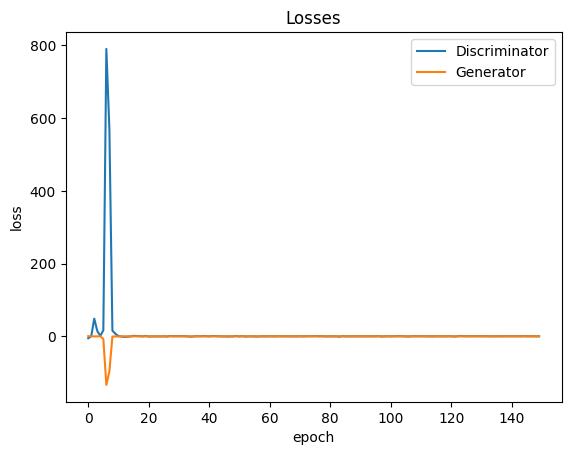

In [36]:
d_losses = history[0]
g_losses = history[1]

d_losses = [tensor.detach().cpu().numpy() for tensor in d_losses]
g_losses = [tensor.detach().cpu().numpy() for tensor in g_losses]

plt.plot(d_losses,'-')
plt.plot(g_losses,'-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator','Generator'])
plt.title('Losses')

Text(0.5, 1.0, 'Scores')

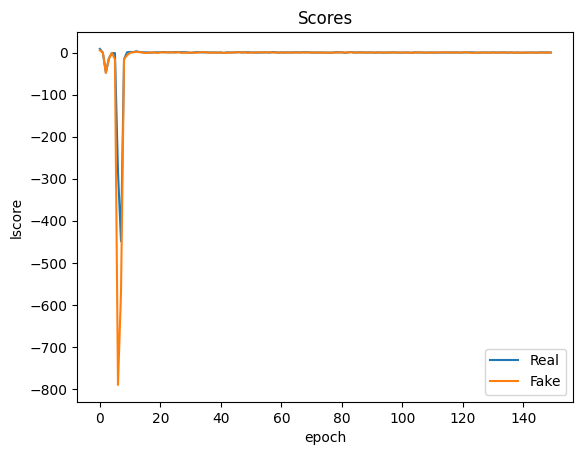

In [14]:
real_scores_mean = history[2]
fake_scores_mean = history[3]

real_scores_mean = [tensor.detach().cpu().numpy() for tensor in real_scores_mean]
fake_scores_mean = [tensor.detach().cpu().numpy() for tensor in fake_scores_mean]

plt.plot(real_scores_mean,'-')
plt.plot(fake_scores_mean,'-')
plt.xlabel('epoch')
plt.ylabel('lscore')
plt.legend(['Real','Fake'])
plt.title('Scores')


In [15]:
# Save the generator and discriminator state dictionaries
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")

In [6]:
#Load the saved models

# Initialize models
latent_dim = 512
img_channels = 3
base_channels = 512

device = "cuda"

generator = StyleGANGenerator(latent_dim, img_channels, base_channels).to(device)
discriminator = StyleGANDiscriminator(img_channels, base_channels).to(device)

# Load the state dictionaries
generator.load_state_dict(torch.load("generator.pth"))
discriminator.load_state_dict(torch.load("discriminator.pth"))

# Ensure the models are in evaluation mode (optional for inference)
generator.eval()
discriminator.eval()



C:\Users\HP\AppData\Local\Temp\ipykernel_10784\3792464041.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("generator.pth"))
C:\User

StyleGANDiscriminator(
  (prog_blocks): ModuleList(
    (0): DiscriminatorBlock(
      (conv1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (downsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (1): DiscriminatorBlock(
      (conv1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (downsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (2): DiscriminatorBlock(
      (conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (downsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (3): DiscriminatorBlock(
      (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_siz

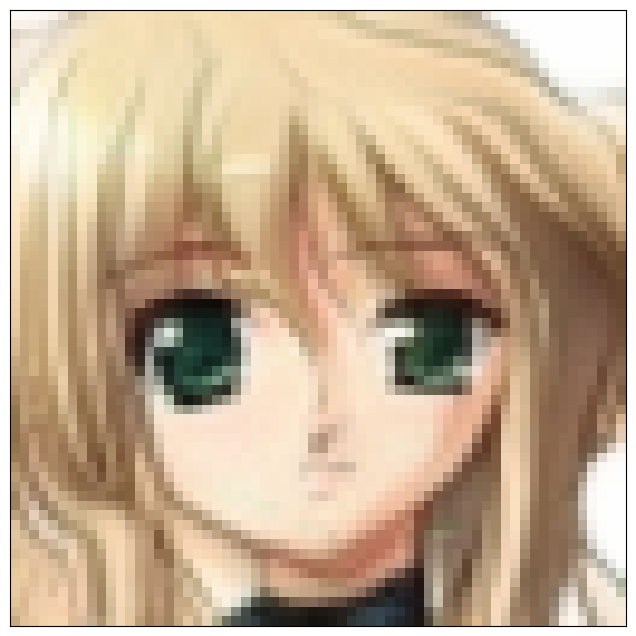

In [20]:
#Create an image using generator of Style GAN

#Create latent input (gaussian noise image)
z = torch.randn(64, latent_dim, device=device)
#Create fake image 
fake_image = generator(z)

show_images(fake_image.to("cpu"), nmax=1)